The goal of this project is to predict whether precipitation will occur on a given day in Atlanta, GA, using basic machine learning and recent historical weather data. I'm not a meteorologist, and so my knowledge of weather forecasting models is limited. There are, doubtlessly, more accurate models that incorporate appropriate physics. However, this project shows the power of simple modeling to give better predictions than randomly guessing would provide.

The data used here was acquired from the NOAA weather database here. These data were taken by equipment at 3 different airports in Atlanta from 1/1/10 to 12/31/19. While the altitudes of these airports vary within 60 meters, they are close enough that the 3 datasets can be combined to give similar measurements. 

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib notebook

from cleaning import *

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [90]:
np.random.seed(42)

In [91]:
path = "/home/chase/Downloads/2049724.csv"
path2 = "/home/chase/Downloads/2069035.csv"
path3 = "/home/chase/Downloads/2069038.csv"

#exclude snow because GA
fields = ['DATE',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageStationPressure',
 'DailyAverageWindSpeed',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed',
 'DailyWeather']

df1 = pd.read_csv(path, parse_dates=['DATE'], usecols=fields, dtype=str)
df2 = pd.read_csv(path2, parse_dates=['DATE'], usecols=fields, dtype=str)
df3 = pd.read_csv(path3, parse_dates=['DATE'], usecols=fields, dtype=str)
#usecols

df = pd.concat([df1,df2,df3], ignore_index=True) # preserving index means elements are series

The first order of business is to import and clean the dataset. The data are stored in csv files that I've uploaded as companions to this project. I created a cleaning function that reads in the data and formats them for use in this project. The function and its helpers are stored and documented in the cleaning.py file. 

In [92]:
df = condense_frame(df)

In order to predict whether there will be precipitation on a given day, the weather event must be encoded numerically. The weather event for each day is stored in the 'DailyWeather' column. The cleaning function automatically encodes each weather event using binary encoding. If there was precipitation on a day, a 1 is stored, and a 0 is stored otherwise. The assignment depends on the NOAA codes that document weather events each day. These can be referenced in the NOAA documentation file.

We can see how many precipitation days there were through counting:

In [93]:
df['DailyWeather'].value_counts()

1    1931
0    1718
Name: DailyWeather, dtype: int64

Now that the data are prepared, we can start learning from the data. The goal is to predict wheather there will be precipitation on a day in Atlanta. This is a binary classification problem since there are 2 possible outcomes: a day is a precipitation day, or it is not. I can take advantage of the straightforward nature of the problem by using a simple model to classify each day. 

A great starting point is to use logistic regression. Essentially, for this problem, logistic regression will produce a model that assigns a probability that a day is a precipitation day based on several predictor variables. If that probability is high enough (P>0.5), then the model predicts a precipitation day. 

So, what are the predictors? The NOAA database contains many types of observations, and these are taken hourly, daily, monthly, and annually. Because I'm modeling a daily event, I'm primarily interested in daily data, so I want to include as many daily variables as available. But I need to exclude data dealing with relative humidity and precipitation amount bacause these would likely confound model predictions. For example, if there is 100% humidity in Atlanta on a given day, then precipitation probably occurred. Similarly, any precipitation amount greater than 0 implies that there was precipitation that day. Including these predictors could obfuscate the importance of the other predictors such as temperature and pressure. Indeed, the correlation of humidity and precipitation with a precipitation event is very high, so removing these predictors will allow us to see better the impact of the other predictors. 

In [94]:
df[['DailyAverageRelativeHumidity', 'DailyPrecipitation','DailyWeather']].corr()['DailyWeather']

DailyAverageRelativeHumidity    0.587900
DailyPrecipitation              0.351726
DailyWeather                    1.000000
Name: DailyWeather, dtype: float64

Here are the other daily variables (excluding snow, because snow is very rare in Atlanta):

In [95]:
predictors = ['DailyAverageDryBulbTemperature',
 'DailyAverageStationPressure',
 'DailyAverageWindSpeed',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed']

Each data point is a measurement averaged over the 3 different airport sensor readings in Atlanta (Hartsfield-Jackson, Fulton County, and Dekalb-Peachtree). The airports are similar in geographic location and altitude, so combining measurements from each gives us better weather data. 

Before I can use these data to create a logistic model, I need to do some preparation. First, I split the dataset into a training and test sets. This will allow a model to be formed based on most of the data and then evaluated on a part of the data the model hasn't see yet to test its accuracy. Next, it's helpful to standardize the data. Standardizing the data puts everything on the same scale, allowing for more meaningful comparisions and reducing the artificial impact that different scales would have on predictions. For this dataset, I use the StandardScaler method from sklearn to preprocess the training and test data. I also use sklearn's simple random splitting function to partition the data. 

In [96]:
X = df[predictors]
y = df['DailyWeather']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

Now, I fit a logistic model onto the data:

In [97]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how accurate this model is. The easiest way to judge accuracy is to calculate the fraction of correct predictions the model has made to the total amount of days in the test set:

In [98]:
model.score(x_test, y_test)

0.7

The accuracy of this logistic model using all the predictors is 70%. Another accuracy metric used for classifiers is called the confusion matrix. This matrix shows the amounts of true positives and true negatives on the diagonal and the false positives and negatives on the off-diagonal elements. 

In [99]:
y_predicted = model.predict(x_test)
confusion_matrix(y_test, y_predicted)

array([[245,  94],
       [125, 266]])

We see that the model has correctly predicted 245 correct precipitation days vs. 94 incorrect preciptation days. Conversely, it has correctly predicted 266 days where there was no precipitation while incorrectly predicting no precipitation on 125 days. 

Lastly, there is way to visualize model accuracy known as the Receiver Operating Characteristic (ROC) curve. Basically, this curve shows the true positive rate of the model at various levels of its false positive rate. Ideally, we want the true positive rate to be 1.0 at all values of the false postive rate. In practice, the true positive rate will vary with the false positive rate, and the ROC curve will be bow-shaped. The worst case scenario is a one-to-one line where the true positive rate is the same as the false positive rate everywhere.

In [100]:
def plot_ROC(false_positive_rate, true_positive_rate): 
    """This function plots the ROC curve for a given model's true and false postive rates."""
    
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='ROC')
    plt.plot([0, 1], [0, 1], 'r-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()

I can now plot the ROC curve for the logistic model using sklearn's ROC function:

<IPython.core.display.Javascript object>


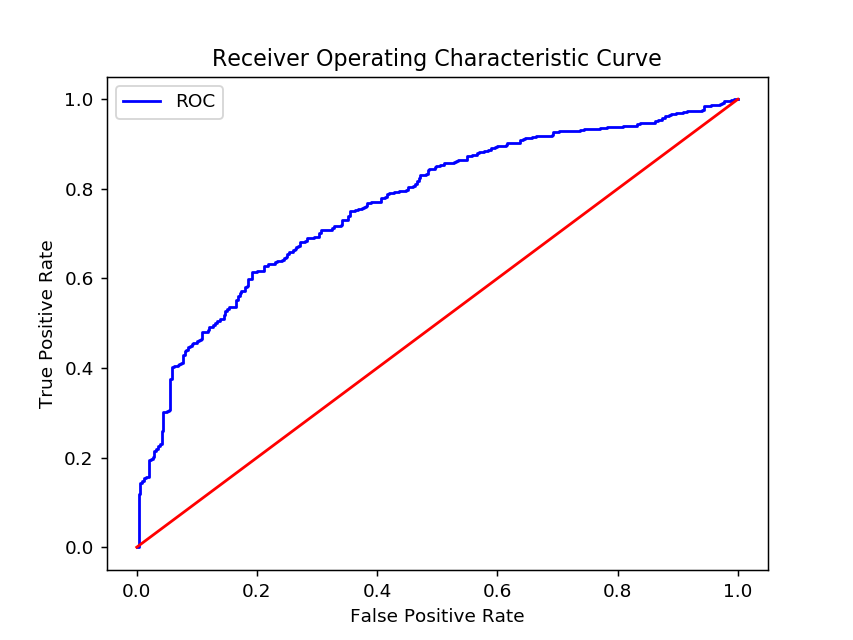

In [101]:
probs = model.predict_proba(x_test)[:,1]
FPR, TPR, _ = roc_curve(y_test, probs) 
plot_ROC(FPR, TPR)

The logistic model gives better results than expected from randomly guessing.  

After looking at the accuracy evaluations above, one can see that the model is a good start, but it leaves much to be desired. Is it possible to improve the model? One consideration to make is that interaction between predictors in the model may reduce accuracy. There are clear similarities between the variables. For example, the predictors include 4 temperature metrics and 5 wind metrics. Perhaps we only need a subset of these predictors to give better results.  

To improve the model, we can try various combinations of predictors to find the best combination that increases model accuracy. I've created a function to iterate over all possible combinations of predictors to find the subset that produces the best logistic model accuracy.

In [102]:
def best_logistic_model(variables, data_frame):
    """
    This function fits a logistic model to all possible subsets of the input variables.
    It returns the best subset of variables along with the accuracy of the logistic 
    model trained using those variables.
    """
    
    y = data_frame['DailyWeather']
    best_variables = []
    score = 0.0
    
    # Iterate over all combinations, increasing in subset cardinality
    for r in range(1, len(variables) + 1):
        for i in itertools.combinations(variables, r):
            i = list(i)
            X = data_frame[i]
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            x_train = StandardScaler().fit_transform(x_train)
            x_test = StandardScaler().fit_transform(x_test)
            model = LogisticRegression()
            model.fit(x_train, y_train)

            if model.score(x_test, y_test) > score:
                best_variables = i
                score = model.score(x_test, y_test)
        
    return best_variables, score

In [103]:
best_subset, accuracy = best_logistic_model(predictors, df)

Using this process, the best predictors subset of predictors is listed below along with the accuracy of the best model.

In [104]:
best_subset

['DailyAverageStationPressure',
 'DailyAverageWindSpeed',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed']

In [105]:
print('model accuracy: {:.3f}'.format(accuracy))

model accuracy: 0.766


An important observation to make here is that the training and test sets are randomly allocated each iteration. This process introduces random variation in the results, so a different subset of optimal variables will be chosen each time the function is run.

Another way of improving model accuracy can be to tune model settings. These model settings are called hyperparameters, and they control various aspects of the model. For example, the 'C' hyperparameter controls the amount of regularization applied to the cost function of the logistic model. Basically, higher regularization means that more complex variables are penalized more in order to prevent the model from iterpreting noise as a legitimate pattern. 

There are only a few relevant hyperparameters for logistic regression, so to find the best ones to use a simple grid search over several hyperparameters can be performed using sklearn's built-in grid search feature:

In [106]:
# Now using the best subset of predictors chosen by the function 
X = df[best_subset]
y = df['DailyWeather']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [107]:
grid = {'C':np.logspace(-5,5,100),
        'penalty':['l1','l2'], 
        'solver':['saga','liblinear']}

method = LogisticRegression()
optum = GridSearchCV(method, grid) # Using 5-fold cross-validation
optum.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-05,...
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05]),
       

The best hyperparameters from the grid search can be displayed:

In [108]:
optum.best_params_

{'C': 2.848035868435799, 'penalty': 'l2', 'solver': 'saga'}

We can use the accuracy metrics we used for the first model to judge this new model:

In [109]:
optum.score(x_test, y_test)

0.7520547945205479

In [110]:
y_predicted = optum.predict(x_test)
confusion_matrix(y_test, y_predicted)

array([[250,  92],
       [ 89, 299]])

<IPython.core.display.Javascript object>


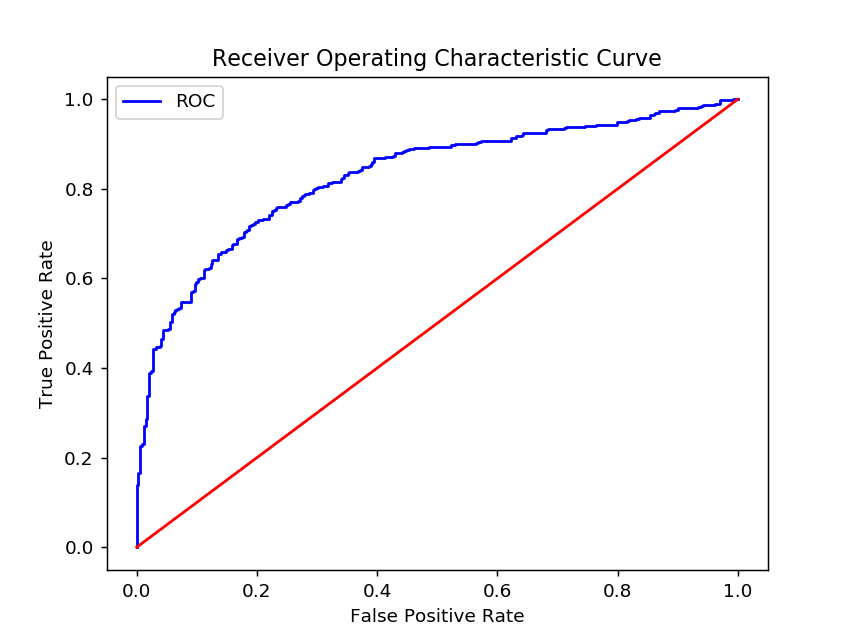

In [111]:
probs = optum.predict_proba(x_test)[:,1]
FPR, TPR, _ = roc_curve(y_test, probs) 
plot_ROC(FPR, TPR)

In this case, tuning the hyperparameters has produced a slightly less accurate model than the model using the  default hyperparameters. Again, the best hyperparameters will change randomly depending on the subset of variables and the random allocation of training and test data. The important takeaway is that the tuning process did not improve the model futher, so I've likely gotten as much out of logistic regression as I can.

Logistic regression has produced models that give predictions better than random chance. But even in the best subset of variables, are still correlations between predictors:

<IPython.core.display.Javascript object>


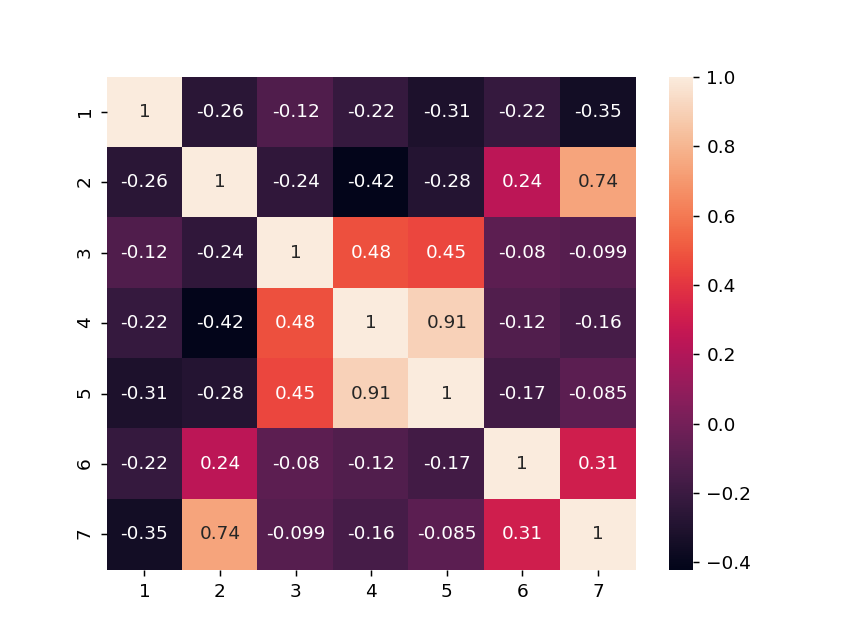

In [122]:
sns.heatmap(df[best_subset].corr(), annot=True, 
            xticklabels=range(1,len(best_subset)+1),
            yticklabels=range(1,len(best_subset)+1))

This introduces the problem of multicollinearity. What this means is that adding correlated variables could have a negative impact on the model's accuracy in predicting precipitation days. Multicollinearity is problematic for linear models like logistic regression because these models work best when each predictor is independent of the others. 

For comparison, we can use a nonlinear model to predict precipitation days. It's possible that the multicollinearity of the predictors puts a limit on the results a logistic model could give us. 

A simple nonlinear model to use is a random forest, which is also implemented in sklearn. One benefit of a random forest model is that it assignes a measure of importance to each predictor used. This means that we can avoid the problem of multicollinearity introduced in logistic regression by letting the random forest model assign value to each predictor appropriately. 

Implementing a random forest model is similar to what I did before: 

In [123]:
# Use all variables for the random forest
X = df[predictors]
y = df['DailyWeather']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [124]:
forest_model = RandomForestClassifier(max_depth=2, n_estimators=1000)
forest_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

We can list each feature and its importance:

In [125]:
for ndx, feature in enumerate(predictors):
    print('{} : {:0.4f}'.format(feature, forest_model.feature_importances_[ndx]))

DailyAverageDryBulbTemperature : 0.0382
DailyAverageStationPressure : 0.2597
DailyAverageWindSpeed : 0.0117
DailyDepartureFromNormalAverageTemperature : 0.1681
DailyMaximumDryBulbTemperature : 0.0213
DailyMinimumDryBulbTemperature : 0.1785
DailyPeakWindDirection : 0.0531
DailyPeakWindSpeed : 0.1210
DailySustainedWindDirection : 0.0388
DailySustainedWindSpeed : 0.1098


The random forest model has identified pressure as the most important predictor of precipitation on a given day. We can observe the same accuracy evaluations as before:

In [126]:
forest_model.score(x_test, y_test)

0.6424657534246575

In [127]:
y_predict = forest_model.predict(x_test)
confusion_matrix(y_test, y_predict)

array([[137, 203],
       [ 58, 332]])

<IPython.core.display.Javascript object>


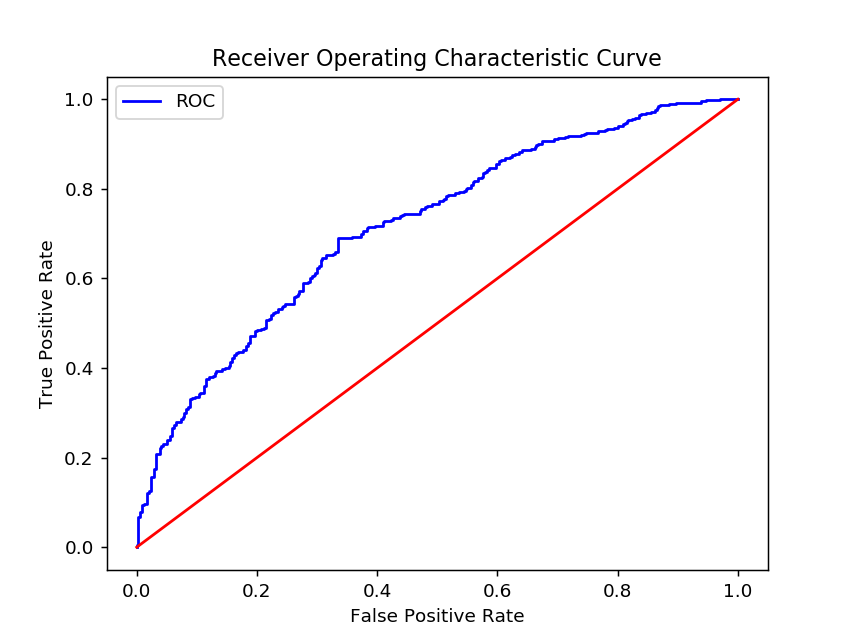

In [128]:
probs = forest_model.predict_proba(x_test)[:,1]
FPR, TPR, _ = roc_curve(y_test, probs) 
plot_ROC(FPR, TPR)

We see that the random forest model gives more accurate predictions than random guesswork, but the accuracy is significantly lower than that of the logistic model. 

For the purposes of predicting precipitation days, the logistic model gives better results. But important limitations must be considered. The 2 wind direction predictors are compass measurements in degrees. Even with standardization, the model may emphasize a difference between 350° and 0° that isn't meaningful. In the encoding process, several different types of precipitation are grouped together to make the system binary. There is clearly a difference between a cold drizzle and a thunderstorm during the summer. Additionally, just becasue the random forest model was worse for this task does not mean that the system is truely linear, so we should still interpret the logistic model results in the context of relationships between the predictors. Finally, this model uses a limited number of predictors. More weather data types could definitely improve any model I used. 

Nevertheless, this project shows that we can use machine learning to improve our insight into a complicated problem. 